In [1]:
!pip install segmentation_models_pytorch


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import segmentation_models_pytorch as smp
from torchvision.models.segmentation import deeplabv3_resnet50
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


#### 2. ETT 資料集分成 5 個 Fold，train 為訓練集、val 為驗證集、test 為預測集；trainannot 為訓練目標遮罩、valannot 為驗證目標遮罩、testannot 為測試目標遮罩。

In [3]:
# 設定根資料夾與 fold 名稱
ROOT_DIR = "ETT_data"
FOLDS = [f"Fold{i}" for i in range(1, 6)]

In [4]:
AUGMENTATIONS = {
    "none": A.Compose([A.Resize(256, 256)]),
    "flip": A.Compose([A.Resize(256, 256), A.HorizontalFlip(p=1.0)]),
    "rotate": A.Compose([A.Resize(256, 256), A.Rotate(limit=15, p=1.0)]),
  "elastic": A.Compose([A.Resize(256, 256), A.ElasticTransform(alpha=1.0, sigma=50.0, approximate=True, p=1.0)])

}

In [5]:
# === 遮罩搜尋邏輯：支援 img_xxx 與 A00010 兩種命名 ===
def find_mask_for_image(basename, mask_dir):
    # 若是 img_xxx，轉為 mask_xxx 匹配
    if basename.startswith("img_"):
        suffix = basename.replace("img_", "")
        candidates = glob(os.path.join(mask_dir, f"mask_{suffix}.*"))
        if candidates:
            return candidates[0]
    # 否則直接用同名方式尋找
    candidates = glob(os.path.join(mask_dir, f"{basename}.*"))
    if candidates:
        return candidates[0]
    return None

In [6]:
# === 主程式：針對每個 Fold 執行 ===
for fold in FOLDS:
    print(f"\n 開始處理：{fold}")

    train_img_dir = os.path.join(ROOT_DIR, fold, "train")
    train_mask_dir = os.path.join(ROOT_DIR, fold, "trainannot")

    out_img_dir = os.path.join(ROOT_DIR, fold, "train_aug")
    out_mask_dir = os.path.join(ROOT_DIR, fold, "trainannot_aug")
    os.makedirs(out_img_dir, exist_ok=True)
    os.makedirs(out_mask_dir, exist_ok=True)

    img_list = sorted(glob(os.path.join(train_img_dir, "*.jpg")))
    print(f" 找到 {len(img_list)} 張影像")

    for img_path in tqdm(img_list, desc=f"處理 {fold}"):
        basename = os.path.splitext(os.path.basename(img_path))[0]  # 不含副檔名

        # 嘗試找出對應遮罩
        mask_path = find_mask_for_image(basename, train_mask_dir)
        if not mask_path:
            print(f"[!] 找不到遮罩：{basename} in {train_mask_dir}")
            continue

        # 讀取影像與遮罩
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            print(f"[!] 無法讀取圖像或遮罩：{basename}")
            continue

        # 儲存原圖與遮罩
        cv2.imwrite(os.path.join(out_img_dir, f"{basename}.jpg"), image)
        cv2.imwrite(os.path.join(out_mask_dir, f"{basename}.png"), mask)

        # 執行增強與儲存
        for aug_name, aug_func in AUGMENTATIONS.items():
            augmented = aug_func(image=image, mask=mask)
            aug_img = augmented['image']
            aug_mask = augmented['mask']

            aug_img_name = f"{basename}_{aug_name}.jpg"
            aug_mask_name = f"{basename}_{aug_name}.png"

            cv2.imwrite(os.path.join(out_img_dir, aug_img_name), aug_img)
            cv2.imwrite(os.path.join(out_mask_dir, aug_mask_name), aug_mask)

print("\n 所有 Fold 的資料擴增已完成！")


 開始處理：Fold1
 找到 287 張影像


處理 Fold1: 100%|██████████| 287/287 [00:17<00:00, 16.08it/s]



 開始處理：Fold2
 找到 287 張影像


處理 Fold2: 100%|██████████| 287/287 [00:17<00:00, 16.40it/s]



 開始處理：Fold3
 找到 287 張影像


處理 Fold3: 100%|██████████| 287/287 [00:17<00:00, 16.69it/s]



 開始處理：Fold4
 找到 285 張影像


處理 Fold4: 100%|██████████| 285/285 [00:17<00:00, 16.05it/s]



 開始處理：Fold5
 找到 285 張影像


處理 Fold5: 100%|██████████| 285/285 [00:17<00:00, 15.94it/s]


 所有 Fold 的資料擴增已完成！



📂 顯示 Fold1 中的一組資料


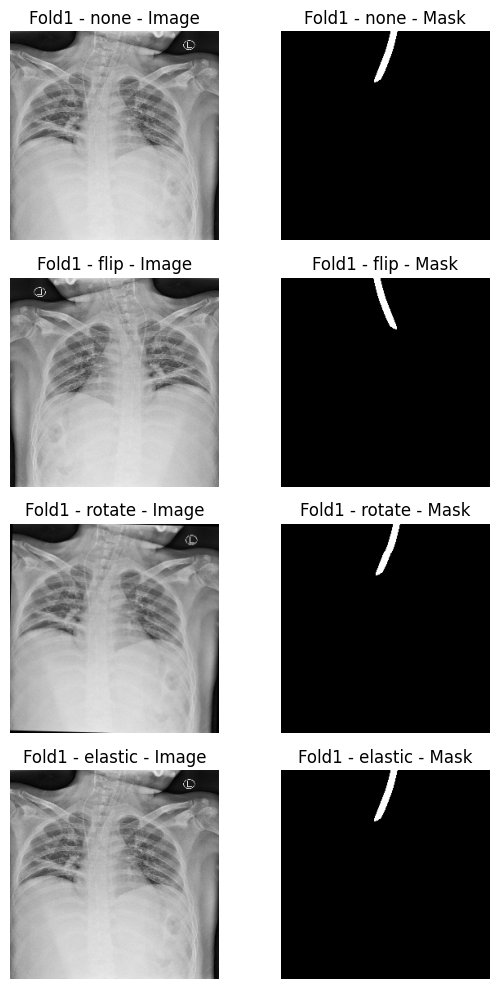


📂 顯示 Fold2 中的一組資料


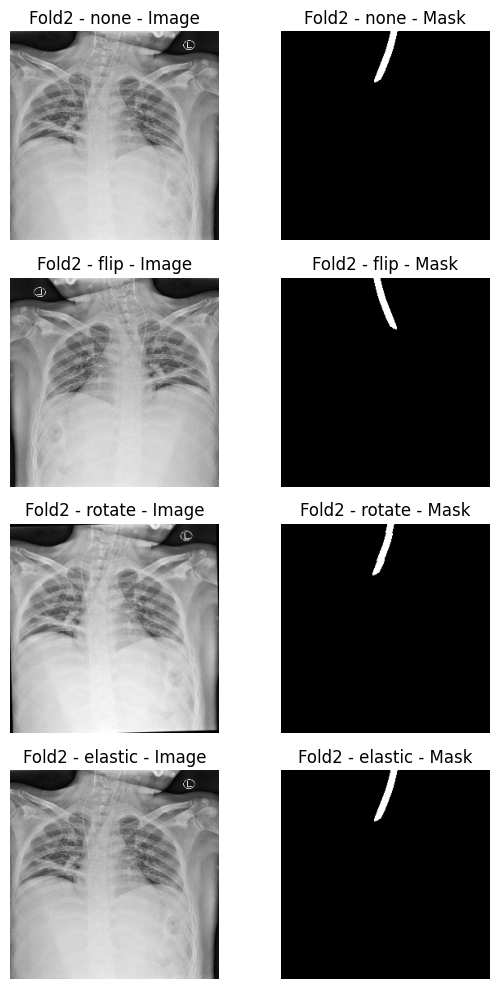


📂 顯示 Fold3 中的一組資料


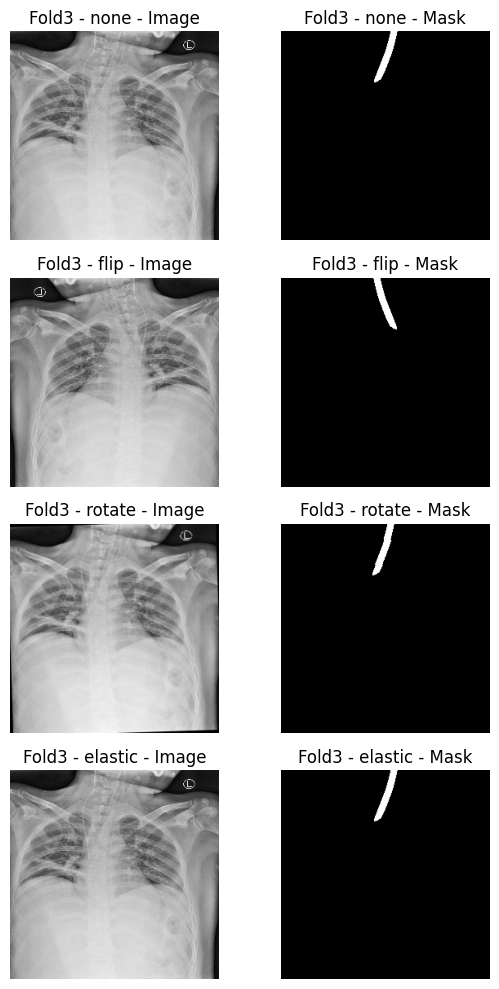


📂 顯示 Fold4 中的一組資料


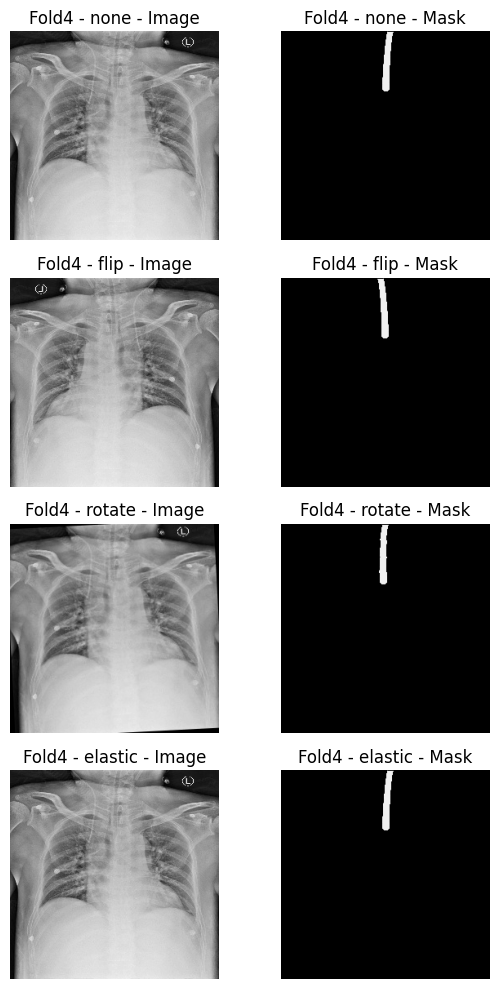


📂 顯示 Fold5 中的一組資料


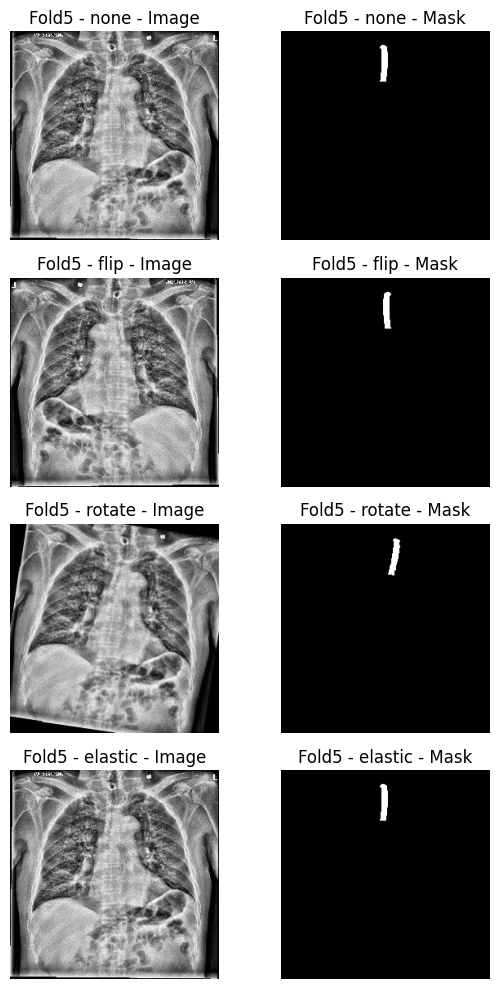

In [7]:
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob

# === 基本設定 ===
ROOT_DIR = "ETT_data"
FOLDS = [f"Fold{i}" for i in range(1, 6)]
AUG_NAMES = ["none", "flip", "rotate", "elastic"]

for fold in FOLDS:
    print(f"\n📂 顯示 {fold} 中的一組資料")

    # 資料夾路徑
    img_aug_dir = os.path.join(ROOT_DIR, fold, "train_aug")
    mask_aug_dir = os.path.join(ROOT_DIR, fold, "trainannot_aug")

    # 嘗試隨機選一張影像（取第一張原始資料）
    img_list = sorted(glob(os.path.join(img_aug_dir, "*_none.jpg")))
    if not img_list:
        print(f"[!] {fold} 無擴增圖像")
        continue

    # 取出 basename，例如 A00010 或 img_xxx
    sample_img_path = img_list[0]
    basename = os.path.basename(sample_img_path).replace("_none.jpg", "")

    # 畫圖
    fig, axs = plt.subplots(len(AUG_NAMES), 2, figsize=(6, 10))
    for idx, aug in enumerate(AUG_NAMES):
        img_path = os.path.join(img_aug_dir, f"{basename}_{aug}.jpg")
        mask_path = os.path.join(mask_aug_dir, f"{basename}_{aug}.png")

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        axs[idx, 0].imshow(img, cmap='gray')
        axs[idx, 0].set_title(f"{fold} - {aug} - Image")
        axs[idx, 0].axis('off')

        axs[idx, 1].imshow(mask, cmap='gray')
        axs[idx, 1].set_title(f"{fold} - {aug} - Mask")
        axs[idx, 1].axis('off')

    plt.tight_layout()
    plt.show()


#### 3. 請使用卷積神經網路(CNN)架構進行訓練及預測，並分別呈現績效。(可用 Github open source 現成的 model, 例如，UNet, UNet++, DeepLab, …等圖像切割模型，需要進行不同模型 之績效比較、需要說明超參數之設定)

In [8]:
class ETTDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # 檢查交集
        image_files = {os.path.splitext(f)[0]: f for f in os.listdir(image_dir)}
        mask_files = {os.path.splitext(f)[0]: f for f in os.listdir(mask_dir)}
        self.filenames = sorted(list(set(image_files.keys()) & set(mask_files.keys())))

        if len(self.filenames) == 0:
            print("找不到圖像與遮罩對應的交集檔案。")

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        for ext in [".jpg", ".png", ".jpeg"]:
            img_path = os.path.join(self.image_dir, fname + ext)
            if os.path.exists(img_path):
                break
        else:
            raise FileNotFoundError(f"找不到圖片：{fname} (支援 jpg/png/jpeg)")

        mask_path = os.path.join(self.mask_dir, fname + ".png")
        if not os.path.exists(mask_path):
            raise FileNotFoundError(f"找不到遮罩：{fname}.png")

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [9]:
def get_model(name):
    if name == "unet":
        return smp.Unet(encoder_name="resnet34", encoder_weights=None, in_channels=3, classes=1)
    elif name == "unetpp":
        return smp.UnetPlusPlus(encoder_name="resnet34", encoder_weights=None, in_channels=3, classes=1)
    elif name == "deeplab":
        model = deeplabv3_resnet50(pretrained=False, num_classes=1)
        return model
    else:
        raise ValueError("模型名稱必須為 'unet'、'unetpp' 或 'deeplab'")


In [10]:
def train_and_eval(model_name, base_dir, fold="Fold1", epochs=3, batch_size=4):
    print(f"開始訓練模型：{model_name.upper()}，資料集：{fold}")
    model = get_model(model_name)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCEWithLogitsLoss()

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    # 載入圖片與遮罩資料夾
    train_images = os.path.join(base_dir, fold, "train")
    train_masks  = os.path.join(base_dir, fold, "trainannot")
    val_images   = os.path.join(base_dir, fold, "val")
    val_masks    = os.path.join(base_dir, fold, "valannot")

    train_dataset = ETTDataset(train_images, train_masks, transform)
    val_dataset = ETTDataset(val_images, val_masks, transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, masks in train_loader:
            #images, masks = images.cuda(), masks.cuda()
            optimizer.zero_grad()
            outputs = model(images)
            if isinstance(outputs, dict):  # 對 DeepLabV3 做特別處理
              outputs = outputs["out"]
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # 驗證階段
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, masks in val_loader:
                #images, masks = images.cuda(), masks.cuda()
                outputs = model(images)
                if isinstance(outputs, dict):  # 對 DeepLabV3 做特別處理
                  outputs = outputs["out"]
                loss = criterion(outputs, masks)
                val_loss += loss.item()

        print(f"[{model_name}] Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


In [11]:
base_dir = "ETT_data/"

train_and_eval("unet", base_dir, fold="Fold1")
train_and_eval("deeplab", base_dir, fold="Fold1")
train_and_eval("unetpp", base_dir, fold="Fold1")

開始訓練模型：UNET，資料集：Fold1
[unet] Epoch 1/3 | Train Loss: 12.1450 | Val Loss: 1.9889
[unet] Epoch 2/3 | Train Loss: 3.0179 | Val Loss: 0.7198
[unet] Epoch 3/3 | Train Loss: 1.6428 | Val Loss: 0.4591
開始訓練模型：DEEPLAB，資料集：Fold1


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[deeplab] Epoch 1/3 | Train Loss: 7.6473 | Val Loss: 0.6351
[deeplab] Epoch 2/3 | Train Loss: 1.2267 | Val Loss: 0.3274
[deeplab] Epoch 3/3 | Train Loss: 0.8074 | Val Loss: 0.2755
開始訓練模型：UNETPP，資料集：Fold1
[unetpp] Epoch 1/3 | Train Loss: 8.0354 | Val Loss: 1.3470
[unetpp] Epoch 2/3 | Train Loss: 2.0536 | Val Loss: 0.5018
[unetpp] Epoch 3/3 | Train Loss: 1.2495 | Val Loss: 0.5389


#### 4. 請使用 IOU 指標評估模型，此外需自行設計三種自定義指標用於計算 ETT 端點的預測位置包括：平均誤差公分、誤差在 0.5 公分內準確率、誤差在 1.0 公分內準確率用於評估模型。

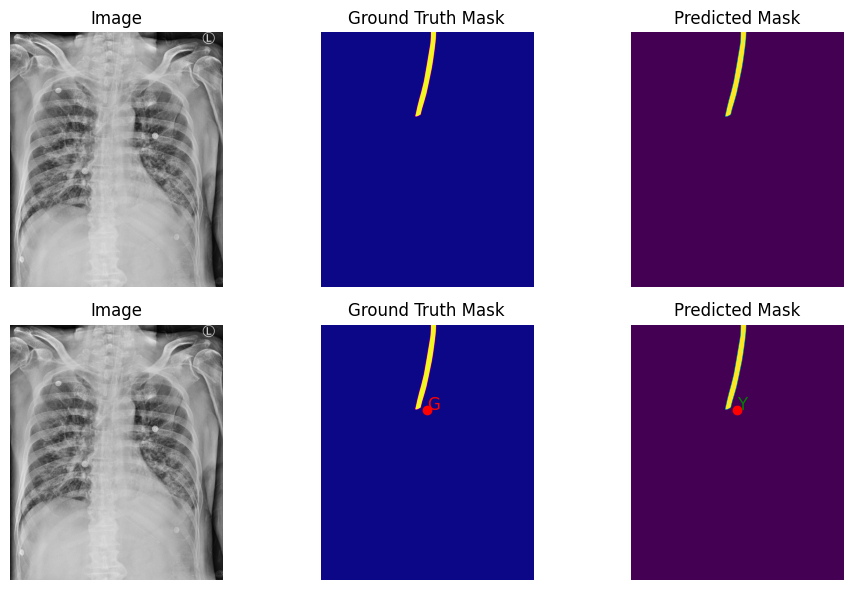

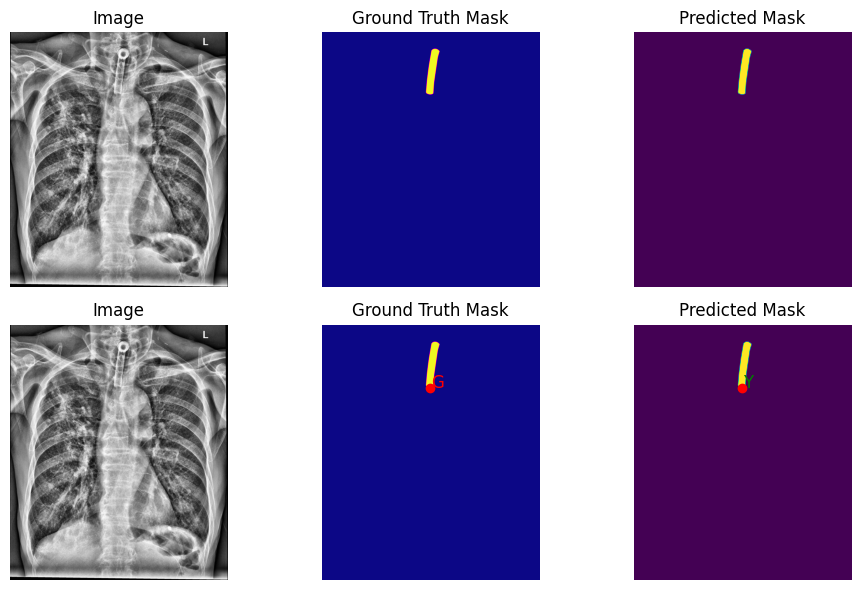

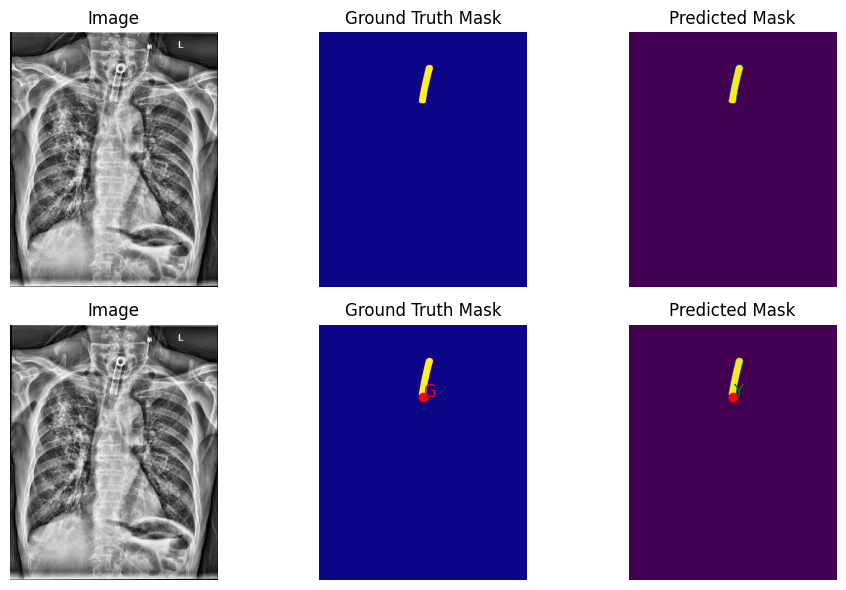

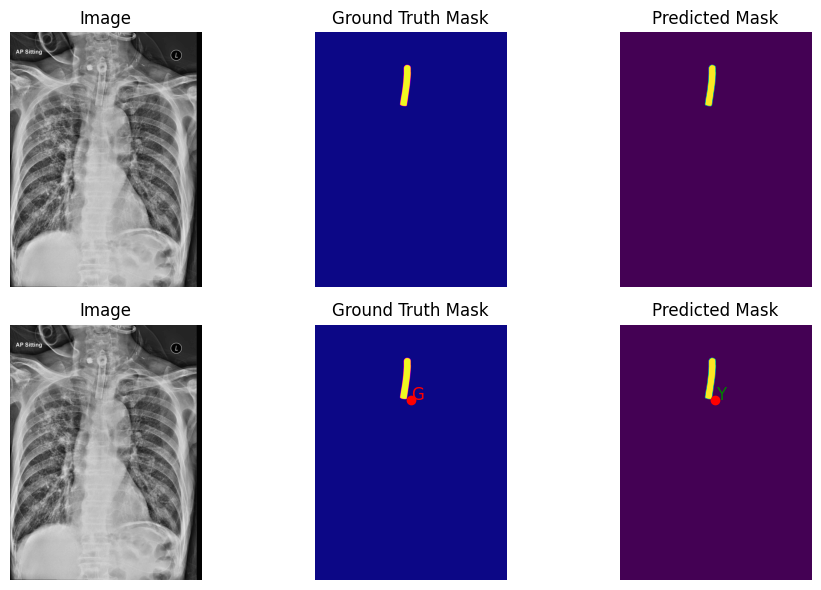

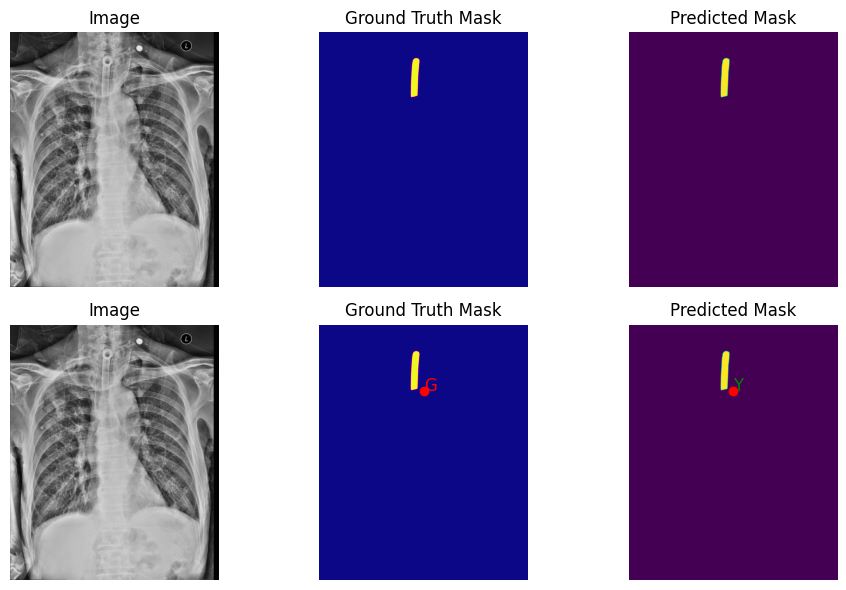

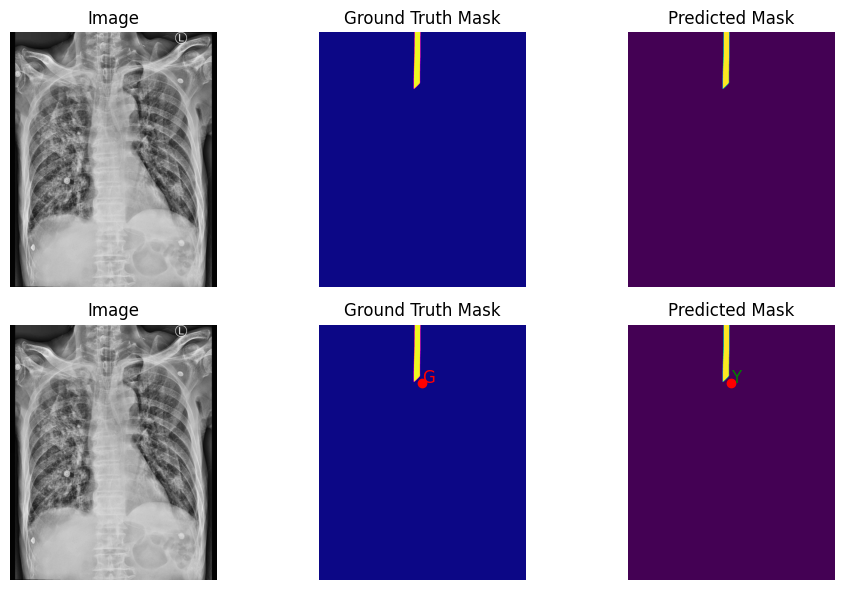

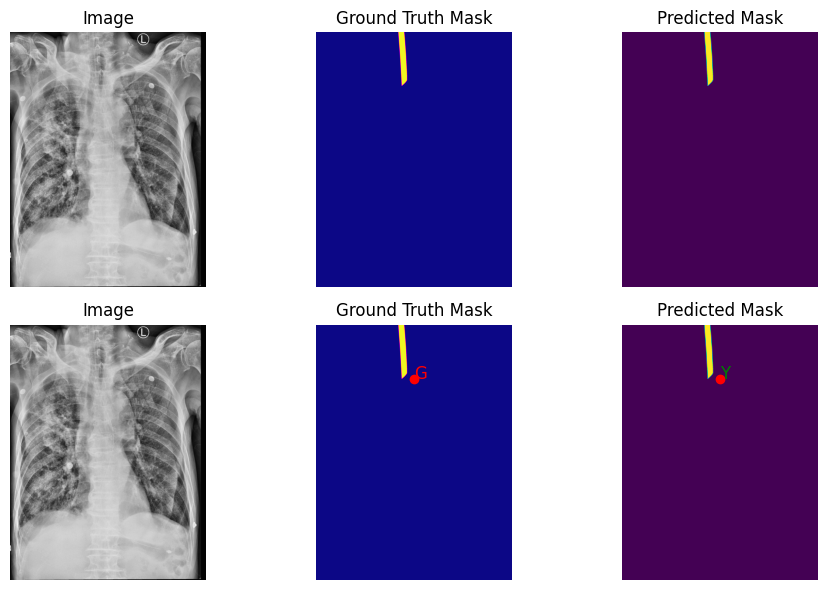

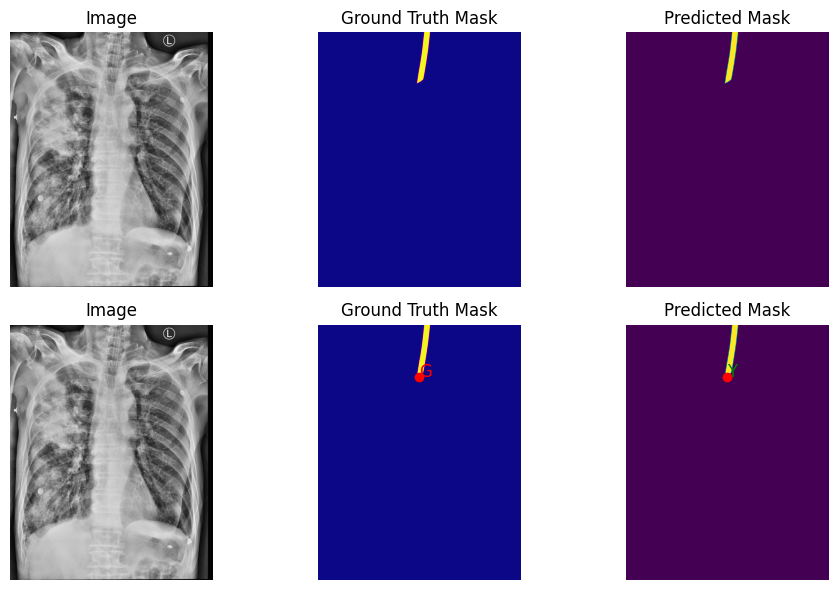

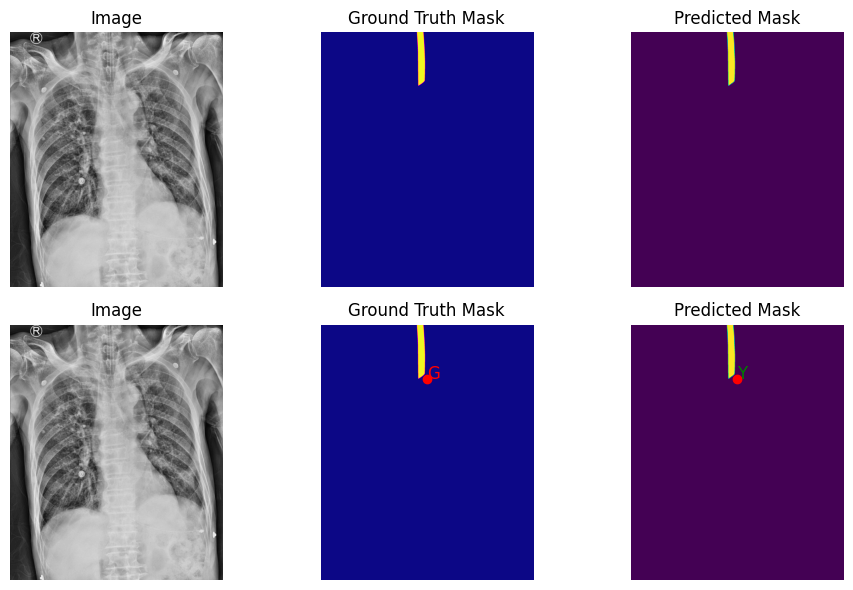

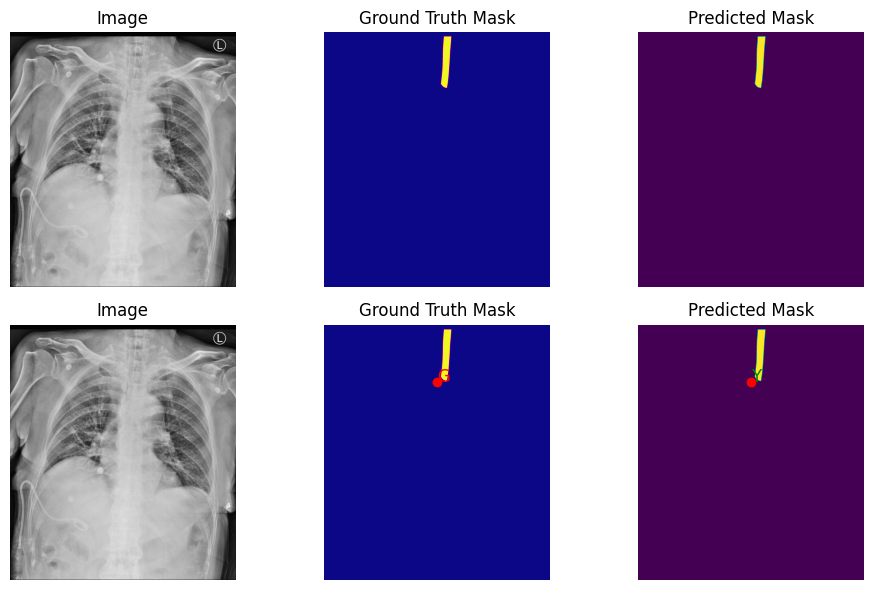

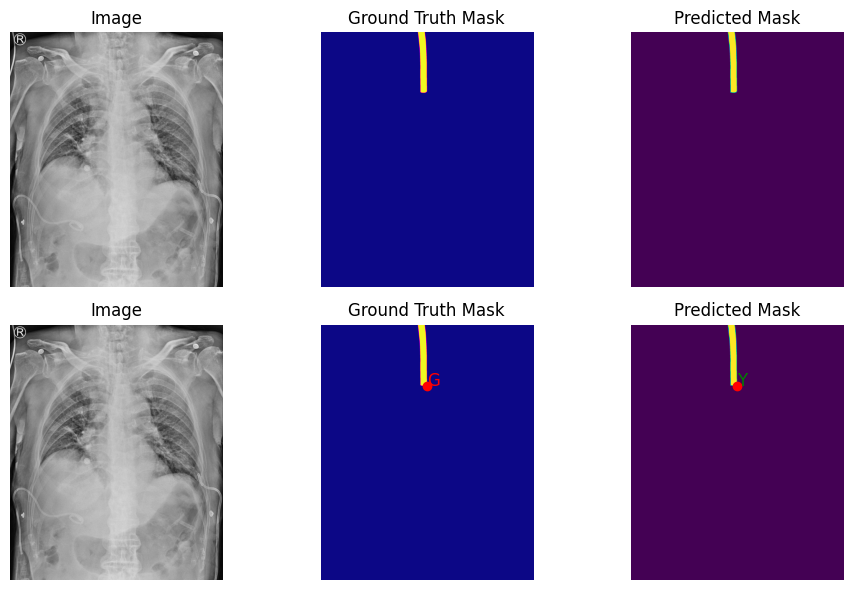

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Helper functions (assuming already defined)
def compute_iou(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()
    return intersection / union if union != 0 else 1.0 if intersection == 0 else 0.0

def get_endpoint_y(mask):
    ys, xs = np.where(mask > 0)
    return ys.max() if len(ys) > 0 else 0

def compute_endpoint_error(pred_y, true_y, pixel_per_cm=72):
    return abs(pred_y - true_y) / pixel_per_cm

def custom_metrics(pred_ys, true_ys, pixel_per_cm=72):
    errors = [compute_endpoint_error(p, t, pixel_per_cm) for p, t in zip(pred_ys, true_ys)]
    return {
        "MAE (cm)": np.mean(errors),
        "Accuracy @ 0.5cm": np.mean([e <= 0.5 for e in errors]),
        "Accuracy @ 1.0cm": np.mean([e <= 1.0 for e in errors]),
    }

def visualize(image, true_mask, pred_mask, pred_y, true_y):
    fig, axs = plt.subplots(2, 3, figsize=(10, 6))

    axs[0, 0].imshow(image, cmap='gray')
    axs[0, 0].set_title("Image")
    axs[0, 1].imshow(true_mask, cmap='plasma')
    axs[0, 1].set_title("Ground Truth Mask")
    axs[0, 2].imshow(pred_mask, cmap='viridis')
    axs[0, 2].set_title("Predicted Mask")

    axs[1, 0].imshow(image, cmap='gray')
    axs[1, 0].set_title("Image")

    axs[1, 1].imshow(true_mask, cmap='plasma')
    axs[1, 1].scatter(true_mask.shape[1]//2, true_y, color='red')
    axs[1, 1].text(true_mask.shape[1]//2 + 3, true_y, "G", color='red', fontsize=12)
    axs[1, 1].set_title("Ground Truth Mask")

    axs[1, 2].imshow(pred_mask, cmap='viridis')
    axs[1, 2].scatter(pred_mask.shape[1]//2, pred_y, color='red')
    axs[1, 2].text(pred_mask.shape[1]//2 + 3, pred_y, "Y", color='green', fontsize=12)
    axs[1, 2].set_title("Predicted Mask")

    for ax in axs.ravel():
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# === Dataset paths ===
base_dir = "ETT_data/Fold3"
test_img_dir = os.path.join(base_dir, "test")
test_mask_dir = os.path.join(base_dir, "testannot")

# === Evaluation ===
ious = []
pred_ys = []
true_ys = []

image_files = sorted(os.listdir(test_img_dir))
mask_files = sorted(os.listdir(test_mask_dir))

for img_name, mask_name in zip(image_files, mask_files):
    img_path = os.path.join(test_img_dir, img_name)
    mask_path = os.path.join(test_mask_dir, mask_name)
    
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    pred_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # assumed prediction == test for now
    true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None or pred_mask is None or true_mask is None:
        continue

    # Threshold
    pred_mask = (pred_mask > 127).astype(np.uint8)
    true_mask = (true_mask > 127).astype(np.uint8)

    # Compute metrics
    iou = compute_iou(pred_mask, true_mask)
    pred_y = get_endpoint_y(pred_mask)
    true_y = get_endpoint_y(true_mask)

    ious.append(iou)
    pred_ys.append(pred_y)
    true_ys.append(true_y)

    # Visualize result for this image
    visualize(image, true_mask, pred_mask, pred_y, true_y)

# === Summary metrics ===
print("Average IoU:", np.mean(ious))
for k, v in custom_metrics(pred_ys, true_ys).items():
    print(f"{k}: {v:.4f}")
